In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import time

import seaborn as sns
import numpy as np

from torch.utils.data import  DataLoader
from torchvision import datasets, transforms

from dataset import ContrastiveDataset
from optimizer import LARS
from loss import NT_Xent
from model import ContrastiveLearningModel

sns.set_theme()

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
seed = 42 
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Dataloader for self-supervised case

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

cifar_train = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
cifar_test = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

train_img_array = np.array([np.array(image) for image, _ in cifar_train])
test_img_array = np.array([np.array(image) for image, _ in cifar_test])

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_dataset = ContrastiveDataset("train", train_img_array[:40000])
val_dataset = ContrastiveDataset("val", train_img_array[40000:])
test_dataset = ContrastiveDataset("test", test_img_array)

In [7]:
ssl_batch_size = 200
num_workers = 0 # means no sub-processes, needed for debugging
train_dataloader = DataLoader(
    train_dataset, batch_size=ssl_batch_size, shuffle=True, num_workers=num_workers
)
val_dataloader = DataLoader(
    val_dataset, batch_size=ssl_batch_size, shuffle=False, num_workers=num_workers
)
test_dataloader = DataLoader(
    test_dataset, batch_size=ssl_batch_size, shuffle=False, num_workers=num_workers
)

In [8]:
model = ContrastiveLearningModel().to(device)
optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=0.2,
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)
criterion = NT_Xent(batch_size=ssl_batch_size, temperature=0.5)

In [9]:
num_epochs = 40

training_losses = []
validation_losses = []
for epoch in range(num_epochs): 

  start = time.time()
  model.train()
  training_loss = 0
  for (x_i, x_j) in train_dataloader: 
    optimizer.zero_grad()
    x_i, x_j = x_i.to(device), x_j.to(device)

    z_i = model(x_i)
    z_j = model(x_j)

    loss = criterion(z_i, z_j)
    loss.backward()

    optimizer.step()
    training_loss += loss.item()
  
  training_loss /= len(train_dataloader)
  training_losses.append(training_loss)
  
  model.eval()
  with torch.no_grad(): 
    validation_loss = 0
    for (x_i, x_j) in val_dataloader: 
      x_i, x_j = x_i.to(device), x_j.to(device)

      z_i = model(x_i)
      z_j = model(x_j)

      loss = criterion(z_i, z_j)
      validation_loss += loss.item()

    validation_loss /= len(val_dataloader)
    validation_losses.append(validation_loss)
    
    end = time.time()
    
  print(f"Epoch #{epoch+1}, training loss: {training_loss}, validation loss: {validation_loss}, time: {end - start:.2f}")

/cluster/work/jssaethe/SSL_project/optimizer.py:132: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1025.)
  next_v.mul_(momentum).add_(scaled_lr, grad)


Epoch #1, training loss: 4.97456280708313, validation loss: 4.376198015213013, time: 184.05
Epoch #2, training loss: 4.442817897796631, validation loss: 4.183467617034912, time: 186.78
Epoch #3, training loss: 4.345142996311187, validation loss: 4.161166410446167, time: 176.69
Epoch #4, training loss: 4.304538214206696, validation loss: 4.13193907737732, time: 176.92
Epoch #5, training loss: 4.275191602706909, validation loss: 4.109586181640625, time: 176.47
Epoch #6, training loss: 4.255799016952515, validation loss: 4.106891975402832, time: 176.79
Epoch #7, training loss: 4.24580753326416, validation loss: 4.1015540218353275, time: 176.53
Epoch #8, training loss: 4.23561849117279, validation loss: 4.108452081680298, time: 177.94
Epoch #9, training loss: 4.227426695823669, validation loss: 4.098489170074463, time: 177.16
Epoch #10, training loss: 4.221007130146027, validation loss: 4.092049160003662, time: 175.01
Epoch #11, training loss: 4.2136726832389835, validation loss: 4.0888745

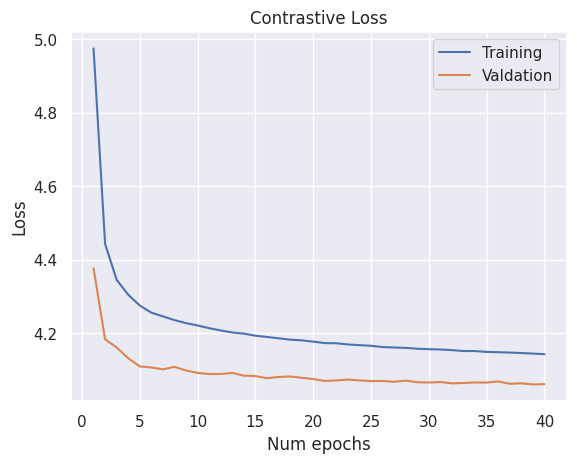

In [10]:
x = np.linspace(1, len(training_losses), len(training_losses))
plt.plot(x, training_losses, label="Training")
plt.plot(x, validation_losses, label="Valdation")

plt.xlabel("Num epochs")
plt.ylabel("Loss")
plt.title("Contrastive Loss")
plt.legend()

plt.show()

In [11]:
# Saving the model to file
model_path = "models/encoder.pth" 
torch.save(model.encoder, model_path)